In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yf

In [2]:
yf.pdr_override()

In [3]:
start = '2010-01-01'
end = '2023-11-30'

df = pdr.get_data_yahoo('^NSEI', start, end)

[*********************100%%**********************]  1 of 1 completed


In [4]:
df.iloc[-5:] # I can also use df.tail() for acheiving the same

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-11-22,19784.000000,19825.550781,19703.849609,19811.849609,19811.849609,184500
2023-11-23,19828.449219,19875.150391,19786.750000,19802.000000,19802.000000,170000
2023-11-24,19809.599609,19832.849609,19768.849609,19794.699219,19794.699219,145900
2023-11-28,19844.650391,19916.849609,19800.000000,19889.699219,19889.699219,229600
2023-11-29,19976.550781,20104.650391,19956.300781,20096.599609,20096.599609,236200


In [5]:
df =df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0
1,2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0
2,2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,5281.799805,0
3,2010-01-07,5281.799805,5302.549805,5244.750000,5263.100098,5263.100098,0
4,2010-01-08,5264.250000,5276.750000,5234.700195,5244.750000,5244.750000,0


In [6]:
# dropping irrelevant columns for training our model
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,5200.899902,5238.450195,5167.100098,5232.200195,0
1,5277.149902,5288.350098,5242.399902,5277.899902,0
2,5278.149902,5310.850098,5260.049805,5281.799805,0
3,5281.799805,5302.549805,5244.750000,5263.100098,0
4,5264.250000,5276.750000,5234.700195,5244.750000,0


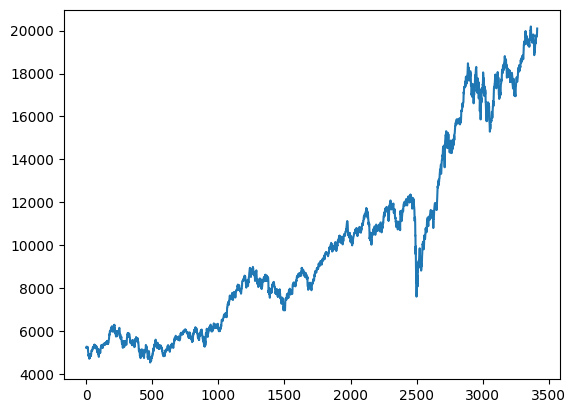

In [7]:
# I am training and Predicting the Close Price in this model so lets plot the close price history
plt.plot(df.Close) # close to 3413 days data

In [8]:
# moving average of 100 days
ma100 = df.Close.rolling(100).mean()

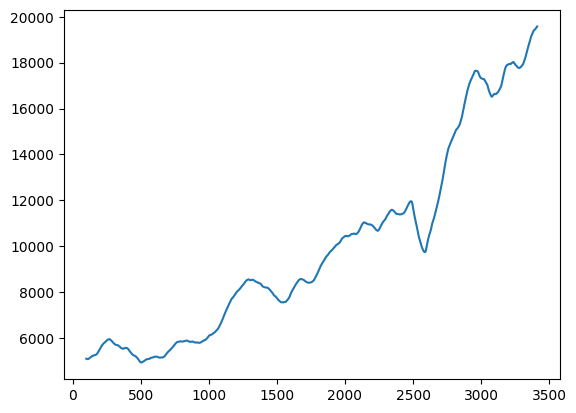

In [9]:
plt.plot(ma100)

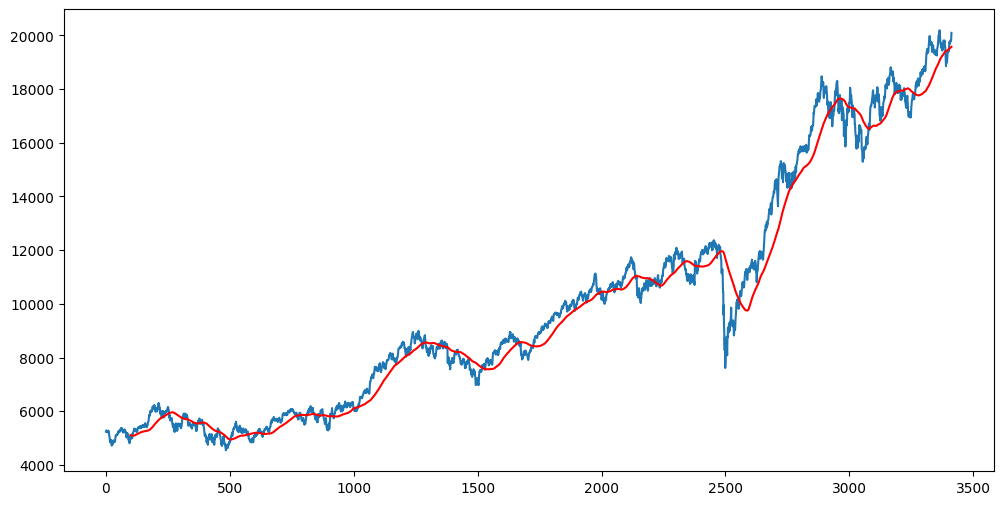

In [10]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')

In [11]:
ma200 = df.Close.rolling(200).mean()

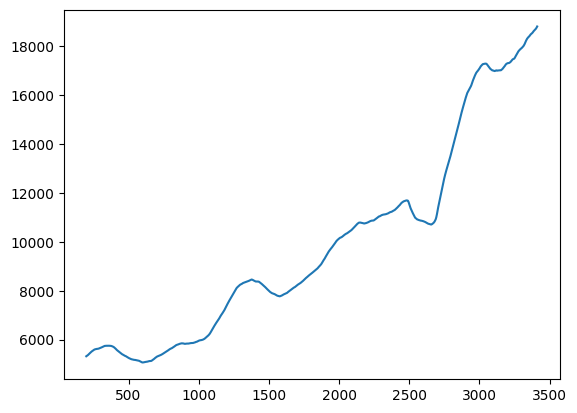

In [12]:
plt.plot(ma200)

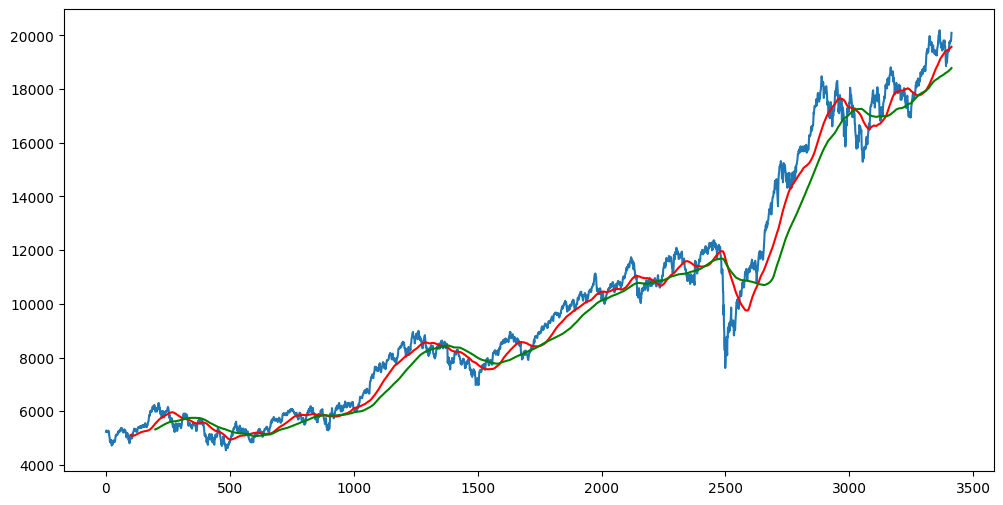

In [13]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

In [14]:
df.shape

(3413, 5)

In [15]:
# Splitting into Test and Training Data Sets
data_training = pd.DataFrame(df['Close'][0: int(len(df)*0.70)])
data_testing = pd.DataFrame(df['Close'][int(len(df)*0.70): len(df)])

print(data_training.shape)
print(data_testing.shape)


(2389, 1)
(1024, 1)


In [16]:
data_training.head()

,Close
0,5232.200195
1,5277.899902
2,5281.799805
3,5263.100098
4,5244.750000


In [17]:
data_testing.tail()

,Close
3408,19811.849609
3409,19802.000000
3410,19794.699219
3411,19889.699219
3412,20096.599609


In [18]:
# We have to normalise the data for quick and efficient training and for the optimiser to get down the steep quicker
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range = (0,1))

In [19]:
data_training_normalised = scaler.fit_transform(data_training)

In [20]:
data_training_normalised # this is an array so we cant call data_training_normalised.head()

array([[0.09119408],
       [0.09725155],
       [0.09776848],
       ...,
       [0.87246755],
       [0.89724098],
       [0.8868027 ]])

In [21]:
# differentiating x_train and y_train for training the model
# the concept I used for differentiating data is : I have considered the past 100 values of the training set to predict the 101th value and after predicting, the first element
# is laid off and the 101th value is added to training set of those 100 values and used to predict 102nd value and so on till the last training value is predicted


In [22]:
x_train = []
y_train = []

for i in range(100, len(data_training_normalised)) :
  x_train.append(data_training_normalised[i-100 : i]) # appends 0th element to 99th element in the x_train (total of 100 elements)
  y_train.append(data_training_normalised[i, 0]) # select the ith value and append to y_train

x_train # it is basically a collection of multiple arrays of size 100 but these are normal arrays, we want them to be numpy array for feeding it in LSTM

x_train, y_train = np.array(x_train), np.array(y_train)

print(x_train)

[[[0.09119408]
  [0.09725155]
  [0.09776848]
  ...
  [0.06082697]
  [0.0692372 ]
  [0.07185505]]

 [[0.09725155]
  [0.09776848]
  [0.09528984]
  ...
  [0.0692372 ]
  [0.07185505]
  [0.0564661 ]]

 [[0.09776848]
  [0.09528984]
  [0.09285755]
  ...
  [0.07185505]
  [0.0564661 ]
  [0.06304717]]

 ...

 [[0.89268135]
  [0.8753571 ]
  [0.88514583]
  ...
  [0.90341786]
  [0.89733379]
  [0.87887626]]

 [[0.8753571 ]
  [0.88514583]
  [0.87652351]
  ...
  [0.89733379]
  [0.87887626]
  [0.87246755]]

 [[0.88514583]
  [0.87652351]
  [0.88979167]
  ...
  [0.87887626]
  [0.87246755]
  [0.89724098]]]


In [23]:
x_train.shape

(2289, 100, 1)

In [24]:
                                                                         #MODEL

In [25]:
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential

In [26]:
model = Sequential()
model.add(LSTM(units = 50, return_sequences = True, input_shape = (x_train.shape[1],1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 120))
model.add(Dropout(0.4))

model.add(Dense(units = 1))

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 60)           26640     
                                                                 
 dropout_1 (Dropout)         (None, 100, 60)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 80)           45120     
                                                                 
 dropout_2 (Dropout)         (None, 100, 80)           0         
                                                                 
 lstm_3 (LSTM)               (None, 120)               9

In [28]:

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x_train,y_train,epochs = 50)

Epoch 1/50
72/72 [==============================] - 13s 34ms/step - loss: 0.0210
Epoch 2/50
72/72 [==============================] - 2s 31ms/step - loss: 0.0041
Epoch 3/50
72/72 [==============================] - 3s 38ms/step - loss: 0.0035
Epoch 4/50
72/72 [==============================] - 3s 40ms/step - loss: 0.0036
Epoch 5/50
72/72 [==============================] - 3s 36ms/step - loss: 0.0036
Epoch 6/50
72/72 [==============================] - 2s 33ms/step - loss: 0.0033
Epoch 7/50
72/72 [==============================] - 1s 18ms/step - loss: 0.0034
Epoch 8/50
72/72 [==============================] - 1s 18ms/step - loss: 0.0030
Epoch 9/50
72/72 [==============================] - 1s 18ms/step - loss: 0.0031
Epoch 10/50
72/72 [==============================] - 2s 23ms/step - loss: 0.0027
Epoch 11/50
72/72 [==============================] - 2s 25ms/step - loss: 0.0031
Epoch 12/50
72/72 [==============================] - 1s 18ms/step - loss: 0.0028
Epoch 13/50
72/72 [=================

In [63]:
 model.save('keras_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [102]:
data_testing.tail(100)

,Close
3313,19398.500000
3314,19497.300781
3315,19331.800781
3316,19355.900391
3317,19439.400391
...,...
3408,19811.849609
3409,19802.000000
3410,19794.699219
3411,19889.699219


In [143]:
# connecting last 100 days of training data to test data
past_100_days = data_training.tail(100)
final_df = past_100_days.append(data_testing) #1124 values but for future prediction lets add smple values of last closing price that is 11234.5498
final_df.tail()

<ipython-input-143-ecd4cabc6821>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_df = past_100_days.append(data_testing) #1124 values but for future prediction lets add smple values of last closing price that is 11234.5498


,Close
3408,19811.849609
3409,19802.000000
3410,19794.699219
3411,19889.699219
3412,20096.599609


In [144]:
# normalise this df
input_data = scaler.fit_transform(final_df)
input_data

array([[0.28188856],
       [0.28984428],
       [0.30177002],
       ...,
       [0.96839555],
       [0.97594595],
       [0.99238998]])

In [145]:
input_data.shape

(1124, 1)

In [146]:
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
  x_test.append(input_data[i-100 : i])
  y_test.append(input_data[i, 0])

x_test, y_test = np.array(x_test), np.array(y_test)

print(x_test)

[[[0.28188856]
  [0.28984428]
  [0.30177002]
  ...
  [0.27945657]
  [0.29431096]
  [0.28805207]]

 [[0.28984428]
  [0.30177002]
  [0.33523817]
  ...
  [0.29431096]
  [0.28805207]
  [0.29365527]]

 [[0.30177002]
  [0.33523817]
  [0.32576833]
  ...
  [0.28805207]
  [0.29365527]
  [0.29652447]]

 ...

 [[0.92025982]
  [0.93087014]
  [0.93615139]
  ...
  [0.96749754]
  [0.96975862]
  [0.9689758 ]]

 [[0.93087014]
  [0.93615139]
  [0.93690643]
  ...
  [0.96975862]
  [0.9689758 ]
  [0.96839555]]

 [[0.93615139]
  [0.93690643]
  [0.94475892]
  ...
  [0.9689758 ]
  [0.96839555]
  [0.97594595]]]


In [147]:
print(x_test.shape)
print(y_test.shape)

(1024, 100, 1)
(1024,)


In [148]:
# prediction
y_predicted = model.predict(x_test)


32/32 [==============================] - 0s 11ms/step


In [149]:
y_predicted.shape

(1024, 1)

In [150]:
y_test


array([0.29365527, 0.29652447, 0.30345093, ..., 0.96839555, 0.97594595,
       0.99238998])

In [151]:
y_predicted

array([[0.28411254],
       [0.28003436],
       [0.2779072 ],
       ...,
       [0.9559015 ],
       [0.95751107],
       [0.95892346]], dtype=float32)

In [152]:
y_test

array([0.29365527, 0.29652447, 0.30345093, ..., 0.96839555, 0.97594595,
       0.99238998])

In [153]:
#scaler.scale_ # scale normalised test values back to original values

In [154]:
scale_factor = 20250.70790114185
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

In [155]:
y_predicted

array([[ 5753.48  ],
       [ 5670.894 ],
       [ 5627.8174],
       ...,
       [19357.682 ],
       [19390.275 ],
       [19418.879 ]], dtype=float32)

In [156]:
y_test

array([ 5946.72701066,  6004.8303832 ,  6145.09610853, ...,
       19610.69533112, 19763.59646132, 20096.59965675])

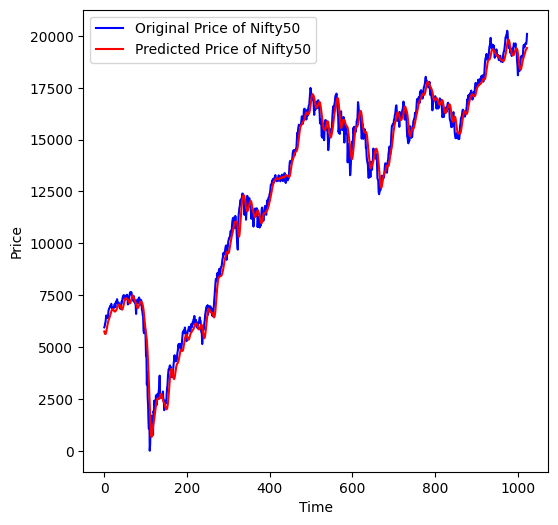

In [157]:

plt.figure(figsize = (6,6))
plt.plot(y_test, 'b', label = 'Original Price of Nifty50')
plt.plot(y_predicted, 'r', label = 'Predicted Price of Nifty50')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()